# Fast Style Transfer with FastEstimator

In this notebook we will demonstrate how to do a neural image style transfer with perceptual loss as described in [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Typical neural style transfer involves two images, an image containing semantics that you want to preserve and another image serving as a reference style; the first image is often referred as *content image* and the other image as *style image*.
In [paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) training images of COCO2014 dataset are used to learn the style transfer from any content image.

In [1]:
import os
import cv2

import fastestimator as fe
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In this notebook we will use *Wassily Kandinsky's Composition 7* as a style image.
We will also resize the style image to $256 \times 256$ to make the dimension consistent with that of COCO images.

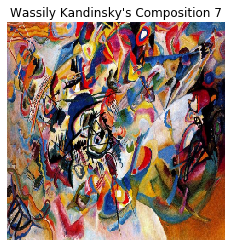

In [38]:
style_img_path = tf.keras.utils.get_file(
    'kandinsky.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
)

style_img = cv2.imread(style_img_path)
style_img = cv2.resize(style_img, (256, 256))
style_img = (style_img.astype(np.float32) - 127.5) / 127.5
style_img_t = tf.convert_to_tensor(np.expand_dims(style_img, axis=0))

style_img_disp = cv2.cvtColor((style_img + 1) * 0.5, cv2.COLOR_BGR2RGB)
plt.imshow(style_img_disp)
plt.title('Wassily Kandinsky\'s Composition 7')
plt.axis('off');

In [ ]:
#Parameters
batch_size = 4
epochs = 2
steps_per_epoch = None
validation_steps = None
img_path = 'panda.jpeg'
saved_model_path = 'style_transfer_net_epoch_1_step_41390.h5'

## Step 1: Input Pipeline

### Downloading the data

First, we will download training images of COCO2014 dataset via our dataset API. 
The images will be first downloaded. Then, a csv file containing relative paths to these images will be created. 
The root path of the downloaded images will be parent_path.
Downloading the images will take awhile.

In [3]:
from fastestimator.dataset.mscoco import load_data
train_csv, path = load_data()

reusing existing dataset


Once finished downloading images, we need to define an *Operator* to recale pixel values from $[0, 255]$ to $[-1, 1]$.
We will define our own `Rescale` class in which we define the data transform logic inside `forward` method.

In [4]:
from fastestimator.op import TensorOp

class Rescale(TensorOp):
    def forward(self, data, state):
        return (tf.cast(data, tf.float32) - 127.5) / 127.5

### Creating tfrecords
Once the images are downloaded, we will create tfrecords using `RecordWriter`.
Each row of the csv file will be used by `ImageReader` to read in the image using `cv2.imread`.
Then, we resize the images to $256 \times 256$.

In [5]:
from fastestimator.op.numpyop import ImageReader, Resize
from fastestimator.util import RecordWriter
tfr_save_dir = os.path.join(path, 'tfrecords')
writer = RecordWriter(
    train_data=train_csv,
    save_dir=tfr_save_dir,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        Resize(inputs="image", target_size=(256, 256), outputs="image")
    ])

### Defining an instance of `Pipeline`
We can now define an instance of `Pipeline`.

In [6]:
pipeline = fe.Pipeline(batch_size=batch_size, data=writer, ops=[Rescale(inputs="image", outputs="image")])

## Step 2: Network
Once `Pipeline` is defined, we need to define network architecture, losses, and the forward pass of batch data.

### Defining model architecture
We first create a `FEModel` instance which collects the following:
* model definition
* model name
* loss name
* optimizer

The architecture of the model is a modified resnet.

In [7]:
from fastestimator.architecture.stnet import styleTransferNet

model = fe.build(model_def=styleTransferNet,
                model_name="style_transfer_net",
                loss_name="loss",
                optimizer=tf.keras.optimizers.Adam(1e-3))

### Defining Loss

The perceptual loss described in the [paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) is computed based on intermediate layers of VGG16 pretrained on ImageNet; specifically, `relu1_2`, `relu2_2`, `relu3_3`, and `relu4_3` of VGG16 are used.
The *style* loss term is computed as the squared l2 norm of the difference in Gram Matrix of these feature maps between an input image and the reference stlye image.
The *content* loss is simply l2 norm of the difference in `relu3_3` of the input image and the reference style image.
In addition, the method also uses total variation loss to enforce spatial smoothness in the output image.
The final loss is weighted sum of the style loss term, the content loss term (feature reconstruction term in the [paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)), and the total variation term.

We first define a custom `TensorOp` that outputs intermediate layers of VGG16.
Given these intermediate layers returned by the loss network as a dictionary, we define a custom `Loss` class that encapsulates all the logics of the loss calculation.
Since `Loss` is also yet another `TensorOp`, the final loss value is returned by `forward` method.

In [8]:
from fastestimator.architecture.stnet import lossNet
from fastestimator.op.tensorop import Loss

class ExtractVGGFeatures(TensorOp):
    def __init__(self, inputs, outputs, mode=None):
        super().__init__(inputs, outputs, mode)
        self.vgg = lossNet()

    def forward(self, data, state):
        return self.vgg(data)

class StyleContentLoss(Loss):
    def __init__(self, style_weight, content_weight, tv_weight, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.tv_weight = tv_weight

    def calculate_style_recon_loss(self, y_true, y_pred):
        y_true_gram = self.calculate_gram_matrix(y_true)
        y_pred_gram = self.calculate_gram_matrix(y_pred)
        y_diff_gram = y_pred_gram - y_true_gram
        y_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(y_diff_gram), axis=(1, 2)))
        return (y_norm)

    def calculate_feature_recon_loss(self, y_true, y_pred):
        y_diff = y_pred - y_true
        num_elts = tf.cast(tf.reduce_prod(y_diff.shape[1:]), tf.float32)
        y_diff_norm = tf.reduce_sum(tf.square(y_diff), axis=(1, 2, 3)) / num_elts
        return (y_diff_norm)

    def calculate_gram_matrix(self, x):
        x = tf.cast(x, tf.float32)
        num_elts = tf.cast(x.shape[1] * x.shape[2] * x.shape[3], tf.float32)
        gram_matrix = tf.einsum('bijc,bijd->bcd', x, x)
        gram_matrix /= num_elts
        return gram_matrix

    def calculate_total_variation(self, y_pred):
        return (tf.image.total_variation(y_pred))

    def forward(self, data, state):
        y_pred, y_style, y_content, image_out = data

        style_loss = [self.calculate_style_recon_loss(a, b) for a, b in zip(y_style['style'], y_pred['style'])]
        style_loss = tf.add_n(style_loss)
        style_loss *= self.style_weight

        content_loss = [
            self.calculate_feature_recon_loss(a, b) for a, b in zip(y_content['content'], y_pred['content'])
        ]
        content_loss = tf.add_n(content_loss)
        content_loss *= self.content_weight

        total_variation_reg = self.calculate_total_variation(image_out)
        total_variation_reg *= self.tv_weight
        return style_loss + content_loss + total_variation_reg


### Defining forward pass

Having defined the model and the associated loss, we can now define an instance of `Network` that specify forward pass of the batch data in a training loop.
FastEstimator takes care of gradient computation and update of the model once this forward pass is defined.

In [9]:
from fastestimator.op.tensorop import ModelOp

style_weight=5.0
content_weight=1.0
tv_weight=1e-4

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="image_out"),
    ExtractVGGFeatures(inputs=lambda: style_img_t, outputs="y_style"),
    ExtractVGGFeatures(inputs="image", outputs="y_content"),
    ExtractVGGFeatures(inputs="image_out", outputs="y_pred"),
    StyleContentLoss(style_weight=style_weight,
                     content_weight=content_weight,
                     tv_weight=tv_weight,
                     inputs=('y_pred', 'y_style', 'y_content', 'image_out'),
                     outputs='loss')
])

## Step 3: Estimator
Having defined `Pipeline` and `Network`, we can now define `Estimator`.
We will use `Trace` to save intermediate models.

In [10]:
from fastestimator.trace import ModelSaver
import tempfile

model_dir=tempfile.mkdtemp()
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         traces=ModelSaver(model_name="style_transfer_net", save_dir=model_dir))

We call `fit` method of `Estimator` to start training.

In [ ]:
estimator.fit()

## Inference

Once the training is finished, we will apply the model to perform the style transfer on arbitrary images.
Here we use a photo of a panda.

In [74]:
test_img = cv2.imread(img_path)
test_img = cv2.resize(test_img, (256, 256))
test_img = (test_img.astype(np.float32) - 127.5) / 127.5
test_img_t = tf.expand_dims(test_img, axis=0)

In [ ]:
model_path = os.path.join(model_dir, saved_model_path)
trained_model = tf.keras.models.load_model(model_path, 
                                           custom_objects={
                                               "ReflectionPadding2D":fe.architecture.stnet.ReflectionPadding2D,
                                               "InstanceNormalization":fe.architecture.stnet.InstanceNormalization},
                                           compile=False)
output_img = trained_model.predict(test_img_t)

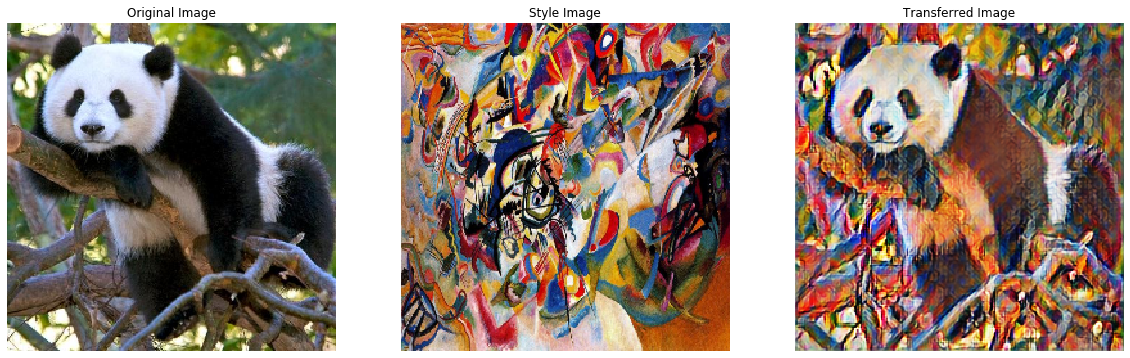

In [76]:
output_img_disp = (output_img[0] + 1) * 0.5
test_img_disp = (test_img + 1) * 0.5
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.imshow(cv2.cvtColor(test_img_disp, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off');

plt.subplot(132)
plt.imshow(style_img_disp)
plt.title('Style Image')
plt.axis('off');

plt.subplot(133)
plt.imshow(cv2.cvtColor(output_img_disp, cv2.COLOR_BGR2RGB));
plt.title('Transferred Image')
plt.axis('off');